In [1]:
# read in the data here
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
df = pd.read_csv('../data/chrom_11_clean.csv', )
df

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1346,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1348,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
X = df.values

In [4]:
from sklearn.decomposition import PCA
n=X.shape[0]
p=X.shape[1]
ncausal_SNPs=30

## Normalize genotype data:
Xmean= np.mean(X, axis=0) #mean of each column, which corresponds to a SNP locus
Xstd= np.std(X,axis=0) #standard deviation of each column
X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations
# of each SNP locus. This is the final X. I use np.nan_to_num in case we get NaN values due to 
# 0 division, i.e. if everything in a column is 0, the mean and standard deviation will also be 0, 
# then we will get NaN values. np.nan_to_num turns NaNs into "0"s. This seemed like a good idea to me
H2= 0.8 #80% of phenotypic variation is explained by genotype (heritability)
rho= 1 #100% of H^2 is explained by additive effects 

<ipython-input-4-a0310b7294ea>:9: RuntimeWarning: invalid value encountered in true_divide
  X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import statistics

In [30]:
def MLpipe_KFold_RMSE(X,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    
    test_scores = []
    best_models = []
    causal_SNPs_list = []
    top_features_list = []
    y_tests = []
    y_preds = []
    
    for i in range(10):
        
        random_state = i * 112
        np.random.seed(random_state)
        causalSNPs = np.random.randint(low=0, high=10000, size=ncausal_SNPs)
        causal_SNPs_list.append(causalSNPs)
        Xadditive = X[:, causalSNPs] #the values for causal SNPs.
        betaAdd = np.repeat(1, ncausal_SNPs)#additive effect sizes initializes as "1"
        y_additive = np.dot(Xadditive, betaAdd) #initialize the value of the portion of phenotypic variation
        # caused by the additive effects as XB.
        betaAdd = betaAdd * np.sqrt(H2*rho/np.var(y_additive)) #Update additive effect sizes based on H^2, rho, and variation
        #in y_additive.
        y_additive = np.dot(Xadditive, betaAdd) #final value of y_additive, updated.
        y_additive = y_additive.reshape(n,1)
        y_noise = np.random.normal(size=n)
        y_noise = y_noise * np.sqrt((1 - H2-0.1) / np.var(y_noise))
        y_noise = y_noise.reshape(n,1)
        y = y_additive + y_noise #np.add(y_additive.reshape(n, 1), y_noise.reshape(n, 1), y_PC, y_epi.reshape(n, 1))
        
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
        y_tests.append(y_test)
        
        kf = KFold(n_splits=4,shuffle=True,random_state= random_state)  
        
        grid = GridSearchCV(estimator = ML_algo, param_grid=param_grid,scoring = 'neg_root_mean_squared_error',
                    cv=kf, return_train_score = True, verbose=True, n_jobs = -1)
        
        grid.fit(X_other, y_other.ravel())
        
        results = pd.DataFrame(grid.cv_results_)
        
        print('best model parameters:',grid.best_params_)
        best_models.append(grid)
        y_test_pred = best_models[-1].predict(X_test)
        y_preds.append(y_test_pred)
        test_scores.append(mean_squared_error(y_test,y_test_pred)**(0.5))
        
        feature_importances = grid.best_estimator_.feature_importances_
        all_snps = np.array(list(range(0, 10000)))
        
        data={'feature_names':all_snps,'feature_importance':feature_importances}
        fi_df = pd.DataFrame(data)
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
        
        top_features = fi_df['feature_names']
        top_features = np.array(top_features)
        top_features_list.append(top_features)        
    
    print(np.mean(test_scores))
    print(np.std(test_scores))
    return best_models, test_scores, causal_SNPs_list, top_features_list, y_tests, y_preds


In [14]:
ML_algo = RandomForestRegressor()
param_grid = {'n_estimators':[100],
             'max_depth':[1, 3, 10, 30, 100,300],
             'max_features':[10, 100, 500, 1000, 5000, 10000]}

models, scores, causal_SNPs_list, top_features_list = MLpipe_KFold_RMSE(X,ML_algo,param_grid)
print(captured_SNPs_list)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  8.5min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  9.0min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 10.2min finished


best model parameters: {'max_depth': 30, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  7.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


best model parameters: {'max_depth': 300, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.7min finished


best model parameters: {'max_depth': 300, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.1min finished


best model parameters: {'max_depth': 100, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  7.3min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
0.7747048825404477
0.1567726102477407
[[3202, 7512, 7525, 454, 1319, 3563, 8779, 6846, 5715, 3412, 1332, 4820, 7159, 2456, 7518, 4799], [1827, 8900, 357, 134, 5829, 7400, 4265, 8554, 479, 915, 2196, 7477, 4694, 8025, 7386, 1661, 6431], [7072, 772, 5349, 7402, 875, 1868, 6285, 722, 7833, 3159, 4761, 4122, 8923], [4835, 1637, 6216, 1320, 4520, 9165, 6574, 1168, 6705, 7506, 1075, 5844, 6740, 4821, 18, 5112, 6295], [4387, 7876, 9894, 6247, 6344, 8649, 9962, 6539, 8844, 4176, 1169, 8145, 8400, 9206, 3736, 3679], [2592, 7359, 6245, 6537, 4394, 6891, 1644, 4525, 4622, 144, 7766, 4855, 728, 410, 8092, 1501, 9695], [8289, 1220, 1962, 8206, 6353, 6706, 3345, 116, 7445, 1010, 1437, 3710], [2144, 7203, 388, 3369, 398, 9742, 974, 1909, 7061, 5176, 4667, 3484, 893], [1383, 5834, 7947, 3404, 2861, 2222, 2735, 2762, 9263, 589, 3539, 9420, 6453, 6963, 407], [9537, 4738, 3907, 7397, 2791, 940, 8206, 463, 3956, 2742, 93

In [17]:
percentage_captured = []
for i in range(len(captured_SNPs_list)):
    captured_percent = len(captured_SNPs_list[i])/ncausal_SNPs
    percentage_captured.append(captured_percent)
np.mean(percentage_captured)
    

0.49393939393939396

### Run again on different hyperparameter grid to further fine-tune. 

In [13]:
ML_algo = RandomForestRegressor()
param_grid = {'n_estimators':[100],
             'max_depth':[30, 100, 300],
             'max_features':[2000, 4000, 6000, 8000, 10000]}

models, scores, causal_SNPs_list, top_features_list, y_tests, y_preds = MLpipe_KFold_RMSE(X,ML_algo,param_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.7min finished


best model parameters: {'max_depth': 30, 'max_features': 4000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.5min finished


best model parameters: {'max_depth': 300, 'max_features': 2000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.1min finished


best model parameters: {'max_depth': 30, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.9min finished


best model parameters: {'max_depth': 300, 'max_features': 6000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.3min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


best model parameters: {'max_depth': 100, 'max_features': 4000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.8min finished


best model parameters: {'max_depth': 30, 'max_features': 4000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.9min finished


best model parameters: {'max_depth': 100, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.3min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.7min finished


best model parameters: {'max_depth': 30, 'max_features': 8000, 'n_estimators': 100}
0.713599868149905
0.1340097381079837


In [14]:
captured_top_30 = []
captured_top_100 = []
captured_top_1000 = []
captured_top_30_p = []
captured_top_100_p = []
captured_top_1000_p = []

for i in range(len(top_features_list)):
    top_features = top_features_list[i]
    causal_SNPs = causal_SNPs_list[i]
    top_30 = top_features_list[i][0:30]
    top_100 = top_features_list[i][0:100]
    top_1000 = top_features_list[i][0:1000]
    captured_SNPs_30 = list(set(top_30).intersection(causal_SNPs))
    captured_SNPs_100 = list(set(top_100).intersection(causal_SNPs))
    captured_SNPs_1000 = list(set(top_1000).intersection(causal_SNPs))
    captured_top_30.append(captured_SNPs_30)
    captured_top_100.append(captured_SNPs_100)
    captured_top_1000.append(captured_SNPs_1000)
    captured_top_30_p.append(len(captured_SNPs_30)/ncausal_SNPs)
    captured_top_100_p.append(len(captured_SNPs_100)/ncausal_SNPs)
    captured_top_1000_p.append(len(captured_SNPs_1000)/ncausal_SNPs)

In [15]:
print(np.mean(captured_top_30_p))
print(np.std(captured_top_30_p))
print(np.mean(captured_top_100_p))
print(np.std(captured_top_100_p))
print(np.mean(captured_top_1000_p))
print(np.std(captured_top_1000_p))

0.4966666666666666
0.08359957469322968
0.7066666666666667
0.05537749241945384
0.7366666666666666
0.05044248650140522


In [16]:
prop_30 = np.mean(captured_top_30_p)
prop_100 = np.mean(captured_top_100_p)
prop_1000 = np.mean(captured_top_1000_p)
std_30 = np.std(captured_top_30_p)
std_100 = np.std(captured_top_100_p)
std_1000 = np.std(captured_top_1000_p)

In [17]:
props = [prop_30, prop_100, prop_1000]
stds = [std_30, std_100, std_1000]
stds_2 = [std_10*2, std_100*2, std_1000*2]

In [18]:
range_top_30_p = [prop_30 - 2*std_30, prop_30+ 2*std_30]
range_top_100_p = [prop_100 - 2*std_100, prop_100+ 2*std_100]
range_top_1000_p = [prop_1000 - 2*std_1000, prop_1000+ 2*std_1000]

In [19]:
print(range_top_30_p)
print(range_top_100_p)
print(range_top_1000_p)

[0.32946751728020723, 0.6638658160531259]
[0.595911681827759, 0.8174216515055743]
[0.6357816936638562, 0.837551639669477]


In [96]:
names = ['Top 30', 'Top 100', 'Top 1000']

In [97]:
props = [0.4966666666666666,0.7066666666666667,0.7366666666666666]
stds_2 = [0.08359957469322968*2,0.05537749241945384*2, 0.050442486501405228*2 ]

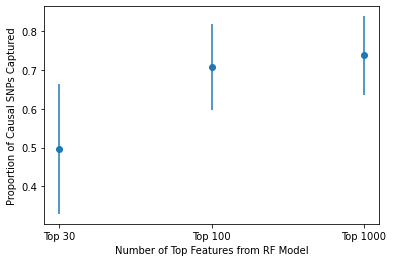

In [98]:
import matplotlib
from matplotlib import pylab as plt
plt.errorbar(names, props,yerr=stds_2,fmt='o')
plt.title('High Heritability With 30 Causal SNPs')
plt.ylabel('Proportion of Causal SNPs Captured')
plt.xlabel('Number of Top Features from RF Model')
plt.show()

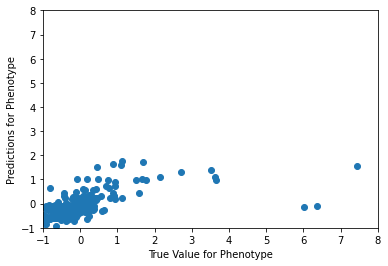

In [29]:
plt.scatter(y_tests[0], y_preds[0])
plt.title('High Heritability With 30 Causal SNPs')
plt.ylabel('Predictions for Phenotype')
plt.xlabel('True Value for Phenotype')
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.show()

In [44]:
example_features = np.sort(top_features_list[0][0:30])
example_causal_snps = np.sort(causal_SNPs_list[0])
data={'feature_names':example_features,'feature_importance':example_causal_snps}
example_df = pd.DataFrame(data)
example_df

,feature_names,feature_importance
0,167,29
1,359,167
2,911,359
3,948,789
4,1300,905
5,2617,911
6,2790,1090
7,2902,1300
8,3270,2101
9,3454,2428


In [48]:
captured_SNPs_30 = list(set(example_features).intersection(example_causal_snps))
captured_SNPs_30

[359,
 167,
 8618,
 9995,
 6988,
 7885,
 911,
 4272,
 4528,
 6575,
 5971,
 1300,
 2902,
 7256,
 6169,
 9020,
 8349,
 7966]

## Different Number of Causal SNPs and Heritability

In [49]:
from sklearn.decomposition import PCA
n=X.shape[0]
p=X.shape[1]
ncausal_SNPs=10

## Normalize genotype data:
Xmean= np.mean(X, axis=0) #mean of each column, which corresponds to a SNP locus
Xstd= np.std(X,axis=0) #standard deviation of each column
X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations
# of each SNP locus. This is the final X. I use np.nan_to_num in case we get NaN values due to 
# 0 division, i.e. if everything in a column is 0, the mean and standard deviation will also be 0, 
# then we will get NaN values. np.nan_to_num turns NaNs into "0"s. This seemed like a good idea to me
H2= 0.8 #90% of phenotypic variation is explained by genotype (heritability)
rho= 1 #100% of H^2 is explained by additive effects 

<ipython-input-49-f3167bcc3144>:9: RuntimeWarning: invalid value encountered in true_divide
  X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations


In [50]:
ML_algo = RandomForestRegressor()
param_grid = {'n_estimators':[100],
             'max_depth':[30, 100, 300],
             'max_features':[2000, 4000, 6000, 8000, 10000]}

models, scores, causal_SNPs_list, top_features_list, y_tests, y_preds = MLpipe_KFold_RMSE(X,ML_algo,param_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


best model parameters: {'max_depth': 300, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.6min finished


best model parameters: {'max_depth': 30, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.4min finished


best model parameters: {'max_depth': 100, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.7min finished


best model parameters: {'max_depth': 30, 'max_features': 6000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.4min finished


best model parameters: {'max_depth': 300, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.8min finished


best model parameters: {'max_depth': 300, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.2min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.4min finished


best model parameters: {'max_depth': 300, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.7min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
0.7605148956104635
0.24199438825091196


In [66]:
captured_top_10 = []
captured_top_100 = []
captured_top_1000 = []
captured_top_10_p = []
captured_top_100_p = []
captured_top_1000_p = []

for i in range(len(top_features_list)):
    top_features = top_features_list[i]
    causal_SNPs = causal_SNPs_list[i]
    top_10 = top_features_list[i][0:10]
    top_100 = top_features_list[i][0:100]
    top_1000 = top_features_list[i][0:1000]
    captured_SNPs_10 = list(set(top_10).intersection(causal_SNPs))
    captured_SNPs_100 = list(set(top_100).intersection(causal_SNPs))
    captured_SNPs_1000 = list(set(top_1000).intersection(causal_SNPs))
    captured_top_10.append(captured_SNPs_10)
    captured_top_100.append(captured_SNPs_100)
    captured_top_1000.append(captured_SNPs_1000)
    captured_top_10_p.append(len(captured_SNPs_10)/ncausal_SNPs)
    captured_top_100_p.append(len(captured_SNPs_100)/ncausal_SNPs)
    captured_top_1000_p.append(len(captured_SNPs_1000)/ncausal_SNPs)

In [67]:
prop_10 = np.mean(captured_top_10_p)
prop_100 = np.mean(captured_top_100_p)
prop_1000 = np.mean(captured_top_1000_p)
std_10 = np.std(captured_top_10_p)
std_100 = np.std(captured_top_100_p)
std_1000 = np.std(captured_top_1000_p)

In [77]:
props = [prop_10, prop_100, prop_1000]
stds = [std_10, std_100, std_1000]
stds_2 = [std_10*2, std_100*2, std_1000*2]

In [69]:
range_top_10_p = [prop_10 - 2*std_10, prop_10+ 2*std_10]
range_top_100_p = [prop_100 - 2*std_100, prop_100+ 2*std_100]
range_top_1000_p = [prop_1000 - 2*std_1000, prop_1000+ 2*std_1000]

In [70]:
print(np.mean(captured_top_10_p))
print(np.std(captured_top_10_p))
print(np.mean(captured_top_100_p))
print(np.std(captured_top_100_p))
print(np.mean(captured_top_1000_p))
print(np.std(captured_top_1000_p))

0.5399999999999999
0.11135528725660043
0.67
0.19000000000000003
0.68
0.18867962264113208


In [71]:
print(range_top_10_p)
print(range_top_100_p)
print(range_top_1000_p)

[0.31728942548679906, 0.7627105745132008]
[0.29, 1.05]
[0.3026407547177359, 1.0573592452822642]


In [72]:
names = ['Top 10', 'Top 100', 'Top 1000']

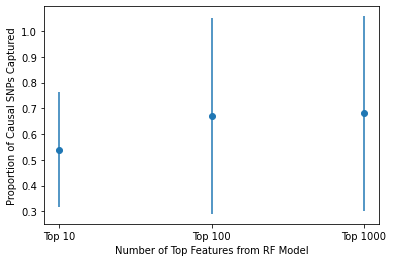

In [78]:
import matplotlib
from matplotlib import pylab as plt
plt.errorbar(names, props,yerr=stds_2,fmt='o')
plt.title('High Heritability With 10 Causal SNPs')
plt.ylabel('Proportion of Causal SNPs Captured')
plt.xlabel('Number of Top Features from RF Model')
plt.show()

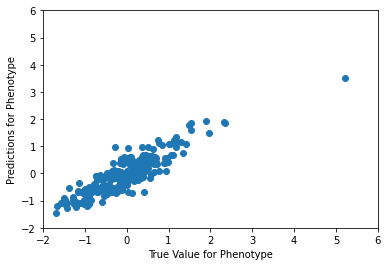

In [79]:
plt.scatter(y_tests[0], y_preds[0])
plt.ylabel('Predictions for Phenotype')
plt.xlabel('True Value for Phenotype')
plt.title('High Heritability With 10 Causal SNPs')
plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.show()

In [80]:
from sklearn.decomposition import PCA
n=X.shape[0]
p=X.shape[1]
ncausal_SNPs=50

## Normalize genotype data:
Xmean= np.mean(X, axis=0) #mean of each column, which corresponds to a SNP locus
Xstd= np.std(X,axis=0) #standard deviation of each column
X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations
# of each SNP locus. This is the final X. I use np.nan_to_num in case we get NaN values due to 
# 0 division, i.e. if everything in a column is 0, the mean and standard deviation will also be 0, 
# then we will get NaN values. np.nan_to_num turns NaNs into "0"s. This seemed like a good idea to me
H2= 0.6 #90% of phenotypic variation is explained by genotype (heritability)
rho= 1 #100% of H^2 is explained by additive effects 

<ipython-input-80-a6312c6cc52a>:9: RuntimeWarning: invalid value encountered in true_divide
  X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations


In [81]:
ML_algo = RandomForestRegressor()
param_grid = {'n_estimators':[100],
             'max_depth':[30, 100, 300],
             'max_features':[2000, 4000, 6000, 8000, 10000]}

models, scores, causal_SNPs_list, top_features_list, y_tests, y_preds = MLpipe_KFold_RMSE(X,ML_algo,param_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.8min finished


best model parameters: {'max_depth': 30, 'max_features': 2000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.2min finished


best model parameters: {'max_depth': 30, 'max_features': 2000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.8min finished


best model parameters: {'max_depth': 100, 'max_features': 4000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.2min finished


best model parameters: {'max_depth': 30, 'max_features': 6000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.2min finished


best model parameters: {'max_depth': 300, 'max_features': 6000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.4min finished


best model parameters: {'max_depth': 300, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.9min finished


best model parameters: {'max_depth': 30, 'max_features': 2000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.5min finished


best model parameters: {'max_depth': 300, 'max_features': 4000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.2min finished


best model parameters: {'max_depth': 300, 'max_features': 4000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.1min finished


best model parameters: {'max_depth': 300, 'max_features': 6000, 'n_estimators': 100}
0.873884701887732
0.08529963152874559


In [99]:
captured_top_50 = []
captured_top_100 = []
captured_top_1000 = []
captured_top_50_p = []
captured_top_100_p = []
captured_top_1000_p = []

for i in range(len(top_features_list)):
    top_features = top_features_list[i]
    causal_SNPs = causal_SNPs_list[i]
    top_50 = top_features_list[i][0:50]
    top_100 = top_features_list[i][0:100]
    top_1000 = top_features_list[i][0:1000]
    captured_SNPs_50 = list(set(top_50).intersection(causal_SNPs))
    captured_SNPs_100 = list(set(top_100).intersection(causal_SNPs))
    captured_SNPs_1000 = list(set(top_1000).intersection(causal_SNPs))
    captured_top_50.append(captured_SNPs_50)
    captured_top_100.append(captured_SNPs_100)
    captured_top_1000.append(captured_SNPs_1000)
    captured_top_50_p.append(len(captured_SNPs_50)/ncausal_SNPs)
    captured_top_100_p.append(len(captured_SNPs_100)/ncausal_SNPs)
    captured_top_1000_p.append(len(captured_SNPs_1000)/ncausal_SNPs)

In [100]:
prop_50 = np.mean(captured_top_50_p)
prop_100 = np.mean(captured_top_100_p)
prop_1000 = np.mean(captured_top_1000_p)
std_50 = np.std(captured_top_50_p)
std_100 = np.std(captured_top_100_p)
std_1000 = np.std(captured_top_1000_p)

In [101]:
props = [prop_50, prop_100, prop_1000]
stds = [std_50, std_100, std_1000]
stds_2 = [std_50*2, std_100*2, std_1000*2]

In [102]:
range_top_50_p = [prop_50 - 2*std_50, prop_50+ 2*std_50]
range_top_100_p = [prop_100 - 2*std_100, prop_100+ 2*std_100]
range_top_1000_p = [prop_1000 - 2*std_1000, prop_1000+ 2*std_1000]

In [103]:
print(np.mean(captured_top_50_p))
print(np.std(captured_top_50_p))
print(np.mean(captured_top_100_p))
print(np.std(captured_top_100_p))
print(np.mean(captured_top_1000_p))
print(np.std(captured_top_1000_p))

0.38
0.07042726744663605
0.528
0.06273754856543248
0.6759999999999999
0.05713142742834282


In [104]:
print(range_top_50_p)
print(range_top_100_p)
print(range_top_1000_p)

[0.2391454651067279, 0.520854534893272]
[0.40252490286913506, 0.6534750971308649]
[0.5617371451433143, 0.7902628548566856]


In [105]:
names = ['Top 50', 'Top 100', 'Top 1000']

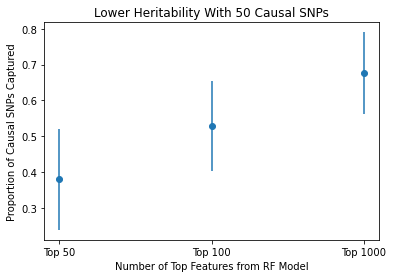

In [107]:
import matplotlib
from matplotlib import pylab as plt
plt.errorbar(names, props,yerr=stds_2,fmt='o')
plt.title('Lower Heritability With 50 Causal SNPs')
plt.ylabel('Proportion of Causal SNPs Captured')
plt.xlabel('Number of Top Features from RF Model')
plt.show()

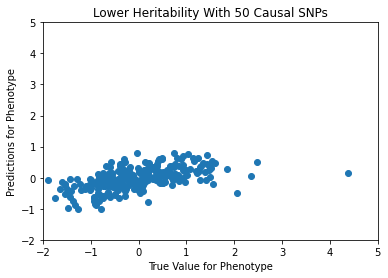

In [108]:
plt.scatter(y_tests[0], y_preds[0])
plt.ylabel('Predictions for Phenotype')
plt.xlabel('True Value for Phenotype')
plt.title('Lower Heritability With 50 Causal SNPs')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()